# Notebook for predicting the waypoint

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cvxpy as cp
import pickle
import numpy as np
import pdb
import time
import random
import sys
import torch
import torch.nn as nn

import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import Sigmoid
from datetime import datetime
import itertools

!pip install gurobipy  # install gurobipy, if not already installed
import gurobipy as gp
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 75.0 MB/s eta 0:00:00


## Loading the data

In [ ]:
# Loading the data
data = np.load("drive/MyDrive/data_simple.npz")
print(data['X'].shape)
print(data['Y'].shape)
print(data['U'].shape)
print(data['solve_times'].shape)
print(data['V'].shape)
print(data['param_x0y0'].shape)

(500000, 2, 3)
(500000, 88, 3)
(500000, 2, 2)
(500000,)
(500000,)
(500000, 2)


## 🏷 Converting labels

In [ ]:
print(np.unique(data['V'][:250000].round()))
old_labels = np.unique(data['V'][:250000].round())
len(np.unique(data['V'][:250000].round()))

[ 0.  4.  6.  7. 10. 13. 16. 17. 21. 23. 24. 26. 33. 34. 40. 41. 42. 47.
 51. 52. 55. 56.]


22

In [ ]:
# We need to make these classes range from 0 to 17
labels = np.array((range(22)))
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [ ]:
v = data['V'][:250000].round()

In [ ]:
for index, label in enumerate(labels):
  v = np.where(v == old_labels[index], label, v)

## Converting from numpy to pytorch and train test split

In [ ]:
v_torch = torch.from_numpy(v).view(-1,1)
x0_torch = torch.from_numpy(data['param_x0y0'][:250000,:][:,0]).view(-1,1) # feature 1
y0_torch = torch.from_numpy(data['param_x0y0'][:250000,:][:,1]).view(-1,1) # feature 2

X = torch.hstack([x0_torch, y0_torch])
y = v_torch

X_train = X[:240000, :]
y_train = y[:240000,:]

In [ ]:
X_test = X[240000:250000, :]
y_test = y[240000:250000, :]

## Defining a simple classifier

In [ ]:
class LinearClassifier(torch.nn.Module):
  def __init__(self, input_dim=2, output_dim=22, n_hidden = 50 ):
    super(LinearClassifier, self).__init__()
    self.fc1 = torch.nn.Linear(input_dim, n_hidden)
    self.fc2 = torch.nn.Linear(n_hidden, n_hidden)
    self.fc3 = torch.nn.Linear(n_hidden, output_dim)


  def forward(self, x):
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    return x

## Training the classifier

In [ ]:
model = LinearClassifier()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

all_loss = []
for epoch in range(10000):
  optimizer.zero_grad()
  output = model(X_train.float())
  loss = criterion(output, y_train.view(-1).long())
  all_loss.append(loss.item())
  loss.backward()
  optimizer.step()
  if not epoch % 100:
    print("Epoch: {} , Loss:{}".format(epoch, loss))
    torch.save(model.state_dict(), 'drive/MyDrive/MIP/Receding + learning/19.12/pred_candidates.ckpt')


Epoch: 0 , Loss:3.0796680450439453
Epoch: 100 , Loss:1.2986379861831665
Epoch: 200 , Loss:0.8382056355476379
Epoch: 300 , Loss:0.639103889465332
Epoch: 400 , Loss:0.5221853256225586
Epoch: 500 , Loss:0.4448431730270386
Epoch: 600 , Loss:0.39172977209091187
Epoch: 700 , Loss:0.35357657074928284
Epoch: 800 , Loss:0.32451745867729187
Epoch: 900 , Loss:0.30072006583213806
Epoch: 1000 , Loss:0.28064942359924316
Epoch: 1100 , Loss:0.2636367082595825
Epoch: 1200 , Loss:0.24903562664985657
Epoch: 1300 , Loss:0.23633679747581482
Epoch: 1400 , Loss:0.22521430253982544
Epoch: 1500 , Loss:0.21531017124652863
Epoch: 1600 , Loss:0.2066703736782074
Epoch: 1700 , Loss:0.1990291178226471
Epoch: 1800 , Loss:0.19223713874816895
Epoch: 1900 , Loss:0.19596658647060394
Epoch: 2000 , Loss:0.1864699423313141
Epoch: 2100 , Loss:0.18140576779842377
Epoch: 2200 , Loss:0.17702966928482056
Epoch: 2300 , Loss:0.17315450310707092
Epoch: 2400 , Loss:0.16962310671806335
Epoch: 2500 , Loss:0.16636605560779572
Epoch: 26

## Plotting the loss

Text(0, 0.5, 'cross entropy loss')

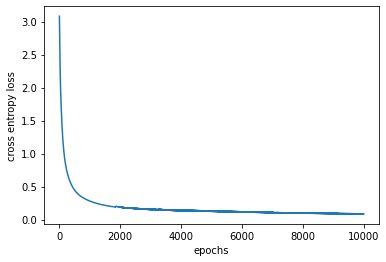

In [ ]:
plt.plot(all_loss)
plt.xlabel('epochs')
plt.ylabel('cross entropy loss')

## Testing the model on the test set

In [ ]:
_, predicted = torch.max(F.softmax(model(X_test.float())),1)

<ipython-input-15-f62ce6de3486>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  _, predicted = torch.max(F.softmax(model(X_test.float())),1)


In [ ]:
y_test = y_test.view(-1).long()
y_test

tensor([ 0,  4, 16,  ..., 21,  6, 21])

In [ ]:
correct = (predicted == y_test).sum().item()
accuracy = 100 * correct / len(y_test)
print('Model accuracy is :{}'.format(accuracy))

Model accuracy is :96.91


## Saving the model !

In [ ]:
torch.save(model.state_dict(), 'drive/MyDrive/pred_candidates.ckpt')